In [196]:
import numpy as np

calibration_data = np.genfromtxt('keithley2000_10Vrange_ca_10Vrangeoutl.csv', delimiter=',')
no_res_data = np.genfromtxt('amplifier_cal_noresistor_10Vout_10Vin.csv', 
		delimiter=',')
res_data = np.genfromtxt('amplifier_cal_resistor_10Vout_10Vin.csv', 
		delimiter=',')

In [25]:
calibration_errors = np.std(calibration_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)
calibration_dmm_volt = np.mean(calibration_data[:, 1].reshape(-1, 10), axis=-1)
calibration_ps_volt = np.mean(calibration_data[:, 0].reshape(-1, 10), axis=-1)

res_ps_volt = np.mean(res_data[:, 0].reshape(-1, 10), axis=-1)
res_dmm_volt = np.mean(res_data[:, 1].reshape(-1, 10), axis=-1)
res_errors = np.std(res_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)

no_res_dmm_volt = np.mean(no_res_data[:, 1].reshape(-1, 10), axis=-1)
no_res_errors = np.std(no_res_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)

calibration_ps_volt, res_ps_volt, res_errors, no_res_errors

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 array([3.08257577e-08, 8.39089454e-08, 5.79176619e-08, 6.84754620e-08,
        3.26598633e-08, 4.42216638e-08, 5.95911999e-08, 2.79880927e-08,
        1.20646407e-07, 4.28952212e-08, 8.83742044e-08, 6.05621811e-08,
        3.28125990e-08, 7.63398832e-08, 8.37721776e-08, 8.23340081e-08,
        1.40035710e-07, 5.58669054e-08, 2.66741656e-07, 9.08539731e-08]),
 array([3.62628413e-07, 9.15472556e-08, 5.52392775e-08, 5.34997404e-08,
        1.42906341e-07, 7.26941843e-08, 5.43752394e-08, 1.36284017e-07,
        7.73448267e-08, 9.89949494e-08, 5.75808609e-08, 1.22365572e-07,
        2.24254320e-07, 9.38142373e-08, 7.34922519e-08, 1.37780018e-07,
        5.97773647e-08, 1.37453022e-07, 2.42798499e-07, 2.23248740e-07]))

In [200]:
import scipy.optimize as opt

# errors for the Keithley 6487 in the 10V output range
def range_10_ps_errors(volt):
    return 0.1*volt/100 + 0.001

def linear_fit(x, *p):
    return p[0]*x + p[1]

calibration_ps_volt_err = range_10_ps_errors(calibration_ps_volt)

calibration_pars = opt.curve_fit(linear_fit, calibration_dmm_volt, calibration_ps_volt, p0=(1, 1e-3), 
    sigma = calibration_ps_volt_err,
    absolute_sigma=False)

m = calibration_pars[0][0]
sigma_m = np.sqrt(calibration_pars[1][0, 0])

b = calibration_pars[0][1]
sigma_b = np.sqrt(calibration_pars[1][1, 1])

sigma_mb = calibration_pars[1][1, 0]

def v_error(V):
    return np.sqrt(sigma_m*sigma_m*V*V + sigma_b*sigma_b + 2*sigma_mb*V)

def v_cal(V):
    return m*V + b

calibration_pars, sigma_m, sigma_b, m, b, sigma_mb

((array([1.00005267e+00, 5.67199656e-05]),
  array([[ 8.18678343e-11, -9.90572724e-11],
         [-9.90572724e-11,  4.03965145e-10]])),
 9.04808456791418e-06,
 2.009888417611065e-05,
 1.0000526733556048,
 5.6719965596231896e-05,
 -9.90572724188769e-11)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

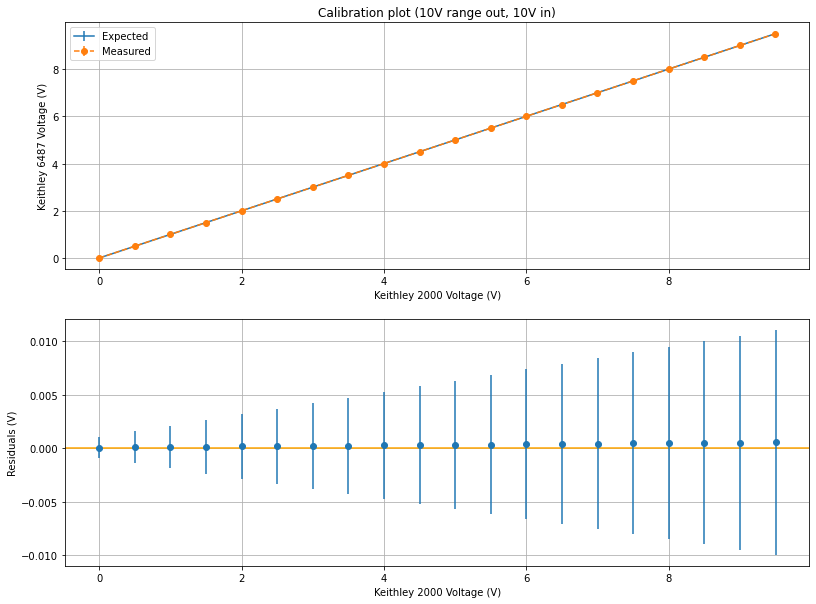

In [210]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13.33333, 10]

volts = np.arange(0.0, 10, 0.5)
v_exp = v_cal(volts)
exp_err = v_error(volts)

plt.subplot(2, 1, 1)
plt.errorbar(volts, v_exp, yerr=exp_err, label="Expected")
plt.errorbar(calibration_dmm_volt, calibration_ps_volt, fmt="--o", yerr=calibration_ps_volt_err, label="Measured")
plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Keithley 6487 Voltage (V)")
plt.title("Calibration plot (10V range out, 10V in)")
plt.grid(True)
plt.legend()

residual_errors = np.sqrt(exp_err**2 + calibration_ps_volt_err**2)
plt.subplot(2, 1, 2)
plt.axhline(y=0, color="orange")
plt.errorbar(volts, v_exp - calibration_ps_volt, yerr=residual_errors, fmt='o', label="Expected")
plt.grid(True)
plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Residuals (V)")

volts

In [211]:
gamma = 3.26363048
gamma_var = 5.64774292e-11
gamma_std = np.sqrt(gamma_var)

gamma_std

7.5151466519290225e-06

In [223]:
R_l = 100e3
Ramp = R_l*m/gamma
Ramp_std = Ramp*np.sqrt((0.02/100)**2 + (sigma_m/m)**2 + (gamma_std/gamma)**2)

Ramp, Ramp_std

(30642.33771206858, 6.135140998164022)